<a href="https://colab.research.google.com/github/Vasquez-505/Data-Science-Projects-/blob/main/docs/notebooks/Training_and_inference_using_Google_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training and inference on your own data using Google Drive

### SLEAP Instalation


In [24]:
!pip uninstall -qqq -y opencv-python opencv-contrib-python
!pip install -qqq "sleap[pypi]>=1.5.1"

# --- Sanity checks ---
import sleap, torch
print(" SLEAP version:", sleap.__version__)
print(" PyTorch version:", torch.__version__)
print(" CUDA available:", torch.cuda.is_available())


 SLEAP version: 1.5.1
 PyTorch version: 2.8.0+cu126
 CUDA available: True


In [25]:
!pip uninstall -qqq -y opencv-python opencv-contrib-python
!pip install -qqq "sleap[pypi]==1.5.1" sleap-io==0.5.5


In [9]:
 !pip install -qqq "sleap-nn[torch-cuda-128]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 144.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.5 MB/s eta 0:00:00


In [26]:
# Sanity Check
import sleap, sleap_io
print("SLEAP:", sleap.__version__)
print("SLEAP-IO:", sleap_io.__version__)

SLEAP: 1.5.1
SLEAP-IO: 0.5.5


### Create and export the training job package
A self-contained **training job package** contains a .slp file with labeled data and images which will be used for training, as well as .json training configuration file(s).

A training job package can be exported in the SLEAP GUI fron the "Run Training.." dialog under the "Predict" menu.

### Upload training job package to Google Drive
To be consistent with the examples in this notebook, name the SLEAP project `colab` and create a directory called `sleap` in the root of your Google Drive. Then upload the exported training job package `colab.slp.training_job.zip` into `sleap` directory.

If you place your training pckage somewhere else, or name it differently, adjust the paths/filenames/parameters below accordingly.

In [29]:
from google.colab import drive
drive.mount('/content/drive/')

ValueError: Mountpoint must not already contain files

In [32]:
## ----- THIS PART IS NOT NEEDED ANYMORE ----- ##

# This step was to import the training package initially. Instead of Importing the training package everytime we want to train a new model,
# just modify the desired parameters in the following MASTER SCRIPT)

# If you haven´t imported a single training package to the drive run this cell


import os
os.chdir("/content/drive/MyDrive/sleap")
!ls
!ls /content/drive/MyDrive


models
sleap


# MASTER Config Trainer Update

In [12]:
# === MASTER CONFIG UPDATER (no inference) ===
# Edits: single_instance.yaml, jobs.yaml, train-script.sh
# Matches your schema exactly.

import os, yaml, datetime, pathlib

# ------------------------------
# PICK YOUR RUN / MODEL NAME HERE
# ------------------------------
RUN_NAME = "drosophila_unet_2_aug_" + datetime.datetime.now().strftime("%y%m%d_%H%M%S")


LABELS_PATH = "colab.pkg.slp"          # or "colab copy.pkg.slp"
# Define where checkpoints should be saved
EXPLICIT_CKPT_DIR = f"models/{RUN_NAME}"

# Prevent double-nesting of model directories
# (SLEAP already creates {ckpt_dir}/{run_name}/... internally)
if RUN_NAME in EXPLICIT_CKPT_DIR:
    CKPT_DIR = "models"
else:
    CKPT_DIR = EXPLICIT_CKPT_DIR


SINGLE_INSTANCE_YAML = "single_instance.yaml"
JOBS_YAML = "jobs.yaml"
TRAIN_SH = "train-script.sh"

# ------------------------------
# FULL PARAMETER BLOCKS (edit anything)
# ------------------------------

DATA_CONFIG = {
    "train_labels_path": [LABELS_PATH],
    "val_labels_path": None,
    "validation_fraction": 0.1,
    "test_file_path": None,
    "provider": "LabelsReader",
    "user_instances_only": True,
    "data_pipeline_fw": "torch_dataset",
    "cache_img_path": None,
    "use_existing_imgs": False,
    "delete_cache_imgs_after_training": True,
    "preprocessing": {
        "ensure_rgb": True,            # set True if your images are RGB
        "ensure_grayscale": False,      # set True if you force grayscale
        "max_height": None,             # e.g., 182
        "max_width": None,              # e.g., 682
        "scale": 1.0,                   # <- critical input scaling
        "crop_size": None,              # or [H, W]
        "min_crop_size": 100,
    },
    "use_augmentations_train": True,
    "augmentation_config": {
        "intensity": {
            "uniform_noise_min": 0.0,
            "uniform_noise_max": 1.0,
            "uniform_noise_p": 0.0,
            "gaussian_noise_mean": 5.0,
            "gaussian_noise_std": 0.0,
            "gaussian_noise_p": 0.0,
            "contrast_min": 0.5,
            "contrast_max": 1.75,
            "contrast_p": 0.0,
            "brightness_min": 0.0,
            "brightness_max": 2.0,
            "brightness_p": 0.0,
        },
        "geometric": {
            "rotation_min": -15.0,
            "rotation_max": 15.0,
            "scale_min": 0.9,
            "scale_max": 1.1,
            "translate_width": 0.0,
            "translate_height": 0.0,
            "affine_p": 1.0,
            "erase_scale_min": 0.0001,
            "erase_scale_max": 0.01,
            "erase_ratio_min": 1.0,
            "erase_ratio_max": 1.0,
            "erase_p": 0.0,
            "mixup_lambda_min": 0.01,
            "mixup_lambda_max": 0.05,
            "mixup_p": 0.0,
        },
    },
    "skeletons": None,
}

MODEL_CONFIG = {
    "init_weights": "default",
    "pretrained_backbone_weights": None,
    "pretrained_head_weights": None,
    "backbone_config": {
        "unet": {
            "in_channels": 1,      # 1 for grayscale, 3 for RGB
            "kernel_size": 3,
            "filters": 32,
            "filters_rate": 1.5,
            "max_stride": 32,
            "stem_stride": None,
            "middle_block": True,
            "up_interpolate": True,
            "stacks": 1,
            "convs_per_block": 2,
            "output_stride": 4,
        },
        "convnext": None,
        "swint": None,
    },
    "head_configs": {
        "single_instance": {
            "confmaps": {
                "part_names": None,   # auto from labels if None
                "sigma": 2.5,
                "output_stride": 4,
            }
        },
        "centroid": None,
        "centered_instance": None,
        "bottomup": None,
        "multi_class_bottomup": None,
        "multi_class_topdown": None,
    },
    "total_params": None,
}

TRAINER_CONFIG = {
    "train_data_loader": {"batch_size": 6, "shuffle": False, "num_workers": 0},
    "val_data_loader": {"batch_size": 6, "shuffle": False, "num_workers": 0},
    "model_ckpt": {"save_top_k": 1, "save_last": False},
    "trainer_devices": None,              # 'auto' or explicit list
    "trainer_device_indices": None,
    "trainer_accelerator": "auto",
    "profiler": None,
    "trainer_strategy": "auto",
    "enable_progress_bar": True,
    "min_train_steps_per_epoch": 200,
    "train_steps_per_epoch": None,
    "visualize_preds_during_training": True,
    "keep_viz": False,
    "max_epochs": 200,
    "seed": None,
    "use_wandb": False,
    "save_ckpt": True,
    "ckpt_dir": CKPT_DIR,
    "run_name": RUN_NAME,
    "resume_ckpt_path": None,
    "wandb": {
        "entity": "",
        "project": "",
        "name": "",
        "save_viz_imgs_wandb": False,
        "api_key": "",
        "wandb_mode": None,
        "prv_runid": "",
        "group": "",
        "current_run_id": None,
    },
    "optimizer_name": "Adam",
    "optimizer": {"lr": 1e-4, "amsgrad": False},
    "lr_scheduler": None,
    "early_stopping": {
        "min_delta": 1e-8,
        "patience": 20,
        "stop_training_on_plateau": True,
    },
    "online_hard_keypoint_mining": {
        "online_mining": False,
        "hard_to_easy_ratio": 2.0,
        "min_hard_keypoints": 2,
        "max_hard_keypoints": None,
        "loss_scale": 5.0,
    },
    "zmq": {
        "controller_port": 9000,
        "controller_polling_timeout": 10,
        "publish_port": 9001,
    },
}

# ------------------------------
# Helpers
# ------------------------------
def _ensure_keys(d, template):
    """Recursively ensure keys from template exist in dict d."""
    if d is None:
        return template
    for k, v in template.items():
        if k not in d or d[k] is None:
            d[k] = v
        else:
            if isinstance(v, dict):
                d[k] = _ensure_keys(d.get(k, {}), v)
    return d

def _safe_update(d, updates):
    """Recursively update d with updates, preserving other keys."""
    for k, v in updates.items():
        if isinstance(v, dict):
            d[k] = _safe_update(d.get(k, {}) if isinstance(d.get(k), dict) else {}, v)
        else:
            d[k] = v
    return d

def _load_yaml(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def _save_yaml(path, data):
    with open(path, "w") as f:
        yaml.safe_dump(data, f, sort_keys=False)

# ------------------------------
# 1) Update single_instance.yaml
# ------------------------------
si = _load_yaml(SINGLE_INSTANCE_YAML)

# Ensure structure exists exactly as your schema
si = _ensure_keys(si, {
    "data_config": {},
    "model_config": {},
    "trainer_config": {},
    "name": "",
    "description": "",
    "sleap_nn_version": si.get("sleap_nn_version", "0.0.2"),
    "filename": "",
})

# Merge updates
si["data_config"]      = _safe_update(si["data_config"], DATA_CONFIG)
si["model_config"]     = _safe_update(si["model_config"], MODEL_CONFIG)
si["trainer_config"]   = _safe_update(si["trainer_config"], TRAINER_CONFIG)
si["trainer_config"]["run_name"] = RUN_NAME
si["trainer_config"]["ckpt_dir"] = CKPT_DIR

# Save
# Ensure model folder exists for cleanliness
pathlib.Path(CKPT_DIR).mkdir(parents=True, exist_ok=True)
_save_yaml = _save_yaml  # avoid accidental shadowing
_save_yaml(SINGLE_INSTANCE_YAML, si)
print(f" Updated {SINGLE_INSTANCE_YAML} with run_name={RUN_NAME}")

# ------------------------------
# 2) Update jobs.yaml (best effort; keeps structure)
# ------------------------------
if os.path.exists(JOBS_YAML):
    jobs = _load_yaml(JOBS_YAML)

    # Try common fields used by Colab templates; only update if present
    # We keep your structure intact.
    def set_if_exists(root, keys, value):
        cur = root
        for k in keys[:-1]:
            if not isinstance(cur, dict) or k not in cur:
                return
            cur = cur[k]
        if isinstance(cur, dict) and keys[-1] in cur:
            cur[keys[-1]] = value

    # Common spots we might find these
    set_if_exists(jobs, ["training_job", "trainer_config", "run_name"], RUN_NAME)
    set_if_exists(jobs, ["training_job", "trainer_config", "ckpt_dir"], CKPT_DIR)
    set_if_exists(jobs, ["training_job", "data_config", "train_labels_path"], [LABELS_PATH])
    set_if_exists(jobs, ["training_job", "config_path"], SINGLE_INSTANCE_YAML)

    _save_yaml(JOBS_YAML, jobs)
    print(f" Updated {JOBS_YAML} (run_name, ckpt_dir, labels if present)")
else:
    print(f" {JOBS_YAML} not found — skipped (that’s fine).")

# ------------------------------
# 3) Update train-script.sh
# ------------------------------
train_script = f"""#!/bin/bash
# Auto-generated: {RUN_NAME}
echo "Starting SLEAP training: {RUN_NAME}"
sleap-train {SINGLE_INSTANCE_YAML} {LABELS_PATH} --first-gpu
"""
with open(TRAIN_SH, "w") as f:
    f.write(train_script)
os.chmod(TRAIN_SH, 0o755)
print(f" Updated {TRAIN_SH}")

print(f"\n Ready. Model/run name: {RUN_NAME}\nCheckpoints: {CKPT_DIR}\nLabels: {LABELS_PATH}")


 Updated single_instance.yaml with run_name=drosophila_unet_1_251019_143552
 Updated jobs.yaml (run_name, ckpt_dir, labels if present)
 Updated train-script.sh

 Ready. Model/run name: drosophila_unet_1_251019_143552
Checkpoints: models
Labels: colab.pkg.slp


## Train a model

Let's train a model with the training profile (.json file) and the project data (.slp file) you have exported from SLEAP.


### Note on training profiles
Depending on the pipeline you chose in the training dialog, the config filename(s) will be:

- for a **bottom-up** pipeline approach: `multi_instance.json` (this is the pipeline we assume here),

- for a **top-down** pipeline, you'll have a different profile for each of the models: `centroid.json` and `centered_instance.json`,

- for a **single animal** pipeline: `single_instance.json`.


### Note on training process
When you start training, you'll first see the training parameters and then the training and validation loss for each training epoch.

As soon as you're satisfied with the validation loss you see for an epoch during training, you're welcome to stop training by clicking the stop button. The version of the model with the lowest validation loss is saved during training, and that's what will be used for inference.

If you don't stop training, it will run for 200 epochs or until validation loss fails to improve for some number of epochs (controlled by the early_stopping fields in the training profile).

In [10]:
!sleap-train single_instance.yaml colab.pkg.slp



INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:sleap.legacy_cli_adaptors:Started training at: 2025-10-19 10:00:11.485656
2025-10-19 10:00:11 | INFO | sleap_nn.training.model_trainer:_setup_train_val_labels:216 | Creating train-val split...
2025-10-19 10:00:12 | INFO | sleap_nn.training.model_trainer:_setup_train_val_labels:261 | # Train Labeled frames: 407
2025-10-19 10:00:12 | INFO | sleap_nn.training.model_trainer:_setup_train_val_labels:262 | # Val Labeled frames: 45
2025-10-19 10:00:12 | INFO | sleap_nn.training.model_trainer:setup_config:512 | Setting up config...
2025-10-19 10:00:12 | INFO | sleap_nn.training.model_trainer:_verify_model_input_channels:417 | Updating backbone in_channels to 3 based on the input image channels.
2025-10-19 10:00:12 | INFO | sleap_nn.training.model_trainer:train:849 | Setting up for training...
2025-10-19 10:00:12 | INFO | sleap_nn.training.model_trainer:_setup_model_ckpt_dir:575 | Setting up model ckpt dir: `models/drosophila_unet_1_251019

# Result Files Generation


📁 Latest model directory: models/drosophila_unet_1_251019_094425

✅ Metrics loaded successfully (51 epochs).
Columns: ['epoch', 'train_loss', 'val_loss', 'learning_rate', 'train_time', 'val_time', 'head1', 'thorax1', 'abdomen1', 'forelegR1', 'forelegL1', 'midlegR1', 'midlegL1', 'hindlegR1', 'hindlegL1']

🔍 Best Model Summary
  • Epoch: 19
  • Validation Loss: 0.00009
  • Training Loss:   0.00004
  • Val/Train Ratio: 1.910 (≈1.0 ideal)

📈 Evaluation metrics (.npz):
  • train_OKS_mAP: 0.9365
  • train_p50_dist: 1.2314
  • train_p90_dist: 2.2193
  • val_OKS_mAP: 0.9063
  • val_p50_dist: 1.3607
  • val_p90_dist: 2.5497
📊 Saved loss curve: models/drosophila_unet_1_251019_094425/loss_curve_20251019_1437.png


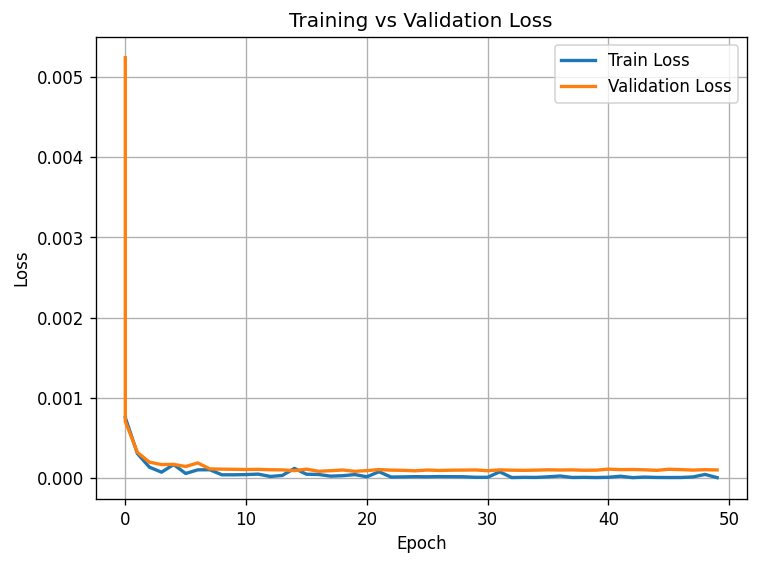


🎯 Per-keypoint validation losses (best epoch):
midlegL1     0.000006
hindlegL1    0.000006
forelegR1    0.000008
head1        0.000020
midlegR1     0.000022
thorax1      0.000022
abdomen1     0.000024
hindlegR1    0.000045
forelegL1    0.000247
📊 Saved keypoint loss plot: models/drosophila_unet_1_251019_094425/keypoint_losses_20251019_1437.png


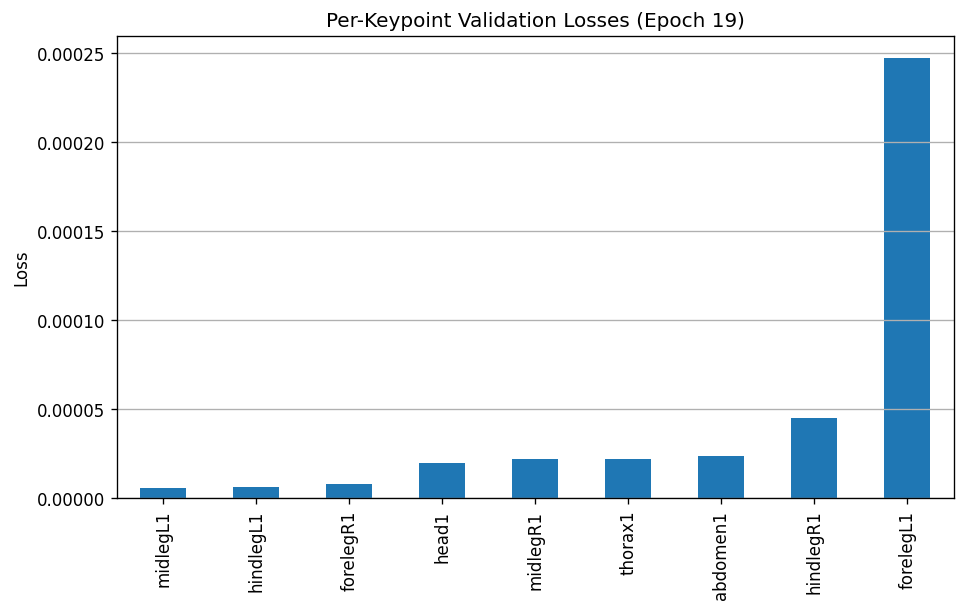


🧾 Summary metrics saved to: models/drosophila_unet_1_251019_094425/summary_metrics.csv

✅ Done! Generated inside model folder:
  • loss_curve_*.png → Training curve
  • keypoint_losses_*.png → Per-keypoint bar plot
  • summary_metrics.csv → Numerical report


In [14]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# =========================================================
# CONFIGURATION
# =========================================================
MODELS_DIR = "models"   # parent folder containing model runs
SAVE_FIGS = True        # save generated figures
plt.rcParams.update({"figure.dpi": 120})

# =========================================================
# Locate latest model (by modification time)
# =========================================================
model_runs = sorted(glob.glob(os.path.join(MODELS_DIR, "*")), key=os.path.getmtime)
if not model_runs:
    raise FileNotFoundError("No model directories found in 'models/'. Check your path.")
latest_model = model_runs[-1]

# Handle nested folder issue (model inside model)
nested = os.path.join(latest_model, os.path.basename(latest_model))
if os.path.isdir(nested):
    print(f" Detected nested run folder, using: {nested}")
    latest_model = nested

print(f"\n Latest model directory: {latest_model}")

# =========================================================
# Load training log (training_log.csv)
# =========================================================
metrics_path = os.path.join(latest_model, "training_log.csv")
if not os.path.exists(metrics_path):
    raise FileNotFoundError(f"No training_log.csv found in {latest_model}")

df = pd.read_csv(metrics_path)
if "epoch" not in df.columns:
    raise ValueError("training_log.csv missing 'epoch' column; check SLEAP output")

print(f"\n Metrics loaded successfully ({len(df)} epochs).")
print(f"Columns: {list(df.columns)}")

# =========================================================
# Identify best epoch (minimum validation loss)
# =========================================================
best_idx = df["val_loss"].idxmin()
best_row = df.loc[best_idx]
best_epoch = int(best_row["epoch"])
best_val_loss = best_row["val_loss"]
best_train_loss = best_row["train_loss"]
loss_ratio = best_val_loss / best_train_loss if best_train_loss != 0 else None

print("\n🔍 Best Model Summary")
print(f"  • Epoch: {best_epoch}")
print(f"  • Validation Loss: {best_val_loss:.5f}")
print(f"  • Training Loss:   {best_train_loss:.5f}")
print(f"  • Val/Train Ratio: {loss_ratio:.3f} (≈1.0 ideal)\n")

# =========================================================
# Load evaluation metrics from .npz files
# =========================================================
train_npz = os.path.join(latest_model, "train_0_pred_metrics.npz")
val_npz = os.path.join(latest_model, "val_0_pred_metrics.npz")

def load_npz_metrics(npz_path, label):
    """Extract OKS, distance, and percentile metrics from SLEAP .npz result files (robust to nested dicts)."""
    if not os.path.exists(npz_path):
        return {}

    try:
        data = np.load(npz_path, allow_pickle=True)
    except Exception as e:
        print(f" Failed to read {npz_path}: {e}")
        return {}

    metrics = {}

    # 1️⃣ Mean OKS (object keypoint similarity)
    if "mOKS.npy" in data.files or "mOKS" in data:
        moks = data["mOKS.npy"] if "mOKS.npy" in data.files else data["mOKS"]
        if isinstance(moks, np.ndarray):
            # unwrap nested dict if needed
            try:
                if moks.dtype == "O" and isinstance(moks.item(), dict):
                    moks = list(moks.item().values())
            except Exception:
                pass
            metrics[f"{label}_OKS_mAP"] = float(np.nanmean(moks))

    # 2️⃣ Distance metrics
    if "distance_metrics.npy" in data.files or "distance_metrics" in data:
        dist = data["distance_metrics.npy"] if "distance_metrics.npy" in data.files else data["distance_metrics"]
        if isinstance(dist, np.ndarray) and dist.dtype == "O":
            try:
                d = dist.item()
                if isinstance(d, dict):
                    for k in ["mean", "p50", "p90"]:
                        if k in d:
                            val = d[k]
                            # unwrap nested dicts or arrays
                            if isinstance(val, dict):
                                val = list(val.values())
                            metrics[f"{label}_{k if k!='mean' else 'avg'}_dist"] = float(np.nanmean(val))
            except Exception:
                pass

    # 3️⃣ Pose correctness (PCK)
    if "pck_metrics.npy" in data.files:
        pck = data["pck_metrics.npy"].item()
        if isinstance(pck, dict) and "mean" in pck:
            val = pck["mean"]
            if isinstance(val, dict):
                val = list(val.values())
            metrics[f"{label}_PCK_mean"] = float(np.nanmean(val))

    return metrics

extra_metrics = {}
extra_metrics.update(load_npz_metrics(train_npz, "train"))
extra_metrics.update(load_npz_metrics(val_npz, "val"))

if extra_metrics:
    print(" Evaluation metrics (.npz):")
    for k, v in extra_metrics.items():
        if not np.isnan(v):
            print(f"  • {k}: {v:.4f}")
else:
    print(" No valid .npz metrics detected (train_0_pred_metrics.npz / val_0_pred_metrics.npz).")

# =========================================================
# Estimate runtime (if available)
# =========================================================
runtime_sec = None
try:
    if "train_time" in df.columns and "val_time" in df.columns:
        runtime_sec = df["train_time"].sum() + df["val_time"].sum()
except Exception:
    pass

# =========================================================
# Plot training vs validation losses
# =========================================================
plt.figure(figsize=(7,5))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss", linewidth=2)
plt.plot(df["epoch"], df["val_loss"], label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

if SAVE_FIGS:
    loss_fig_path = os.path.join(latest_model, f"loss_curve_{datetime.now().strftime('%Y%m%d_%H%M')}.png")
    plt.savefig(loss_fig_path, dpi=300, bbox_inches="tight")
    print(f" Saved loss curve: {loss_fig_path}")
plt.show()

# =========================================================
# Per-keypoint validation losses
# =========================================================
keypoint_cols = [c for c in df.columns if any(k in c for k in ["head", "thorax", "leg", "abdomen"])]

if keypoint_cols:
    best_keypoint_losses = df.loc[best_idx, keypoint_cols].sort_values()
    print("\n Per-keypoint validation losses (best epoch):")
    print(best_keypoint_losses.round(6).to_string())

    plt.figure(figsize=(9,5))
    best_keypoint_losses.plot.bar()
    plt.ylabel("Loss")
    plt.title(f"Per-Keypoint Validation Losses (Epoch {best_epoch})")
    plt.grid(True, axis='y')
    if SAVE_FIGS:
        kp_fig_path = os.path.join(latest_model, f"keypoint_losses_{datetime.now().strftime('%Y%m%d_%H%M')}.png")
        plt.savefig(kp_fig_path, dpi=300, bbox_inches="tight")
        print(f"📊 Saved keypoint loss plot: {kp_fig_path}")
    plt.show()

# =========================================================
# Export summary metrics to CSV
# =========================================================
summary = {
    "model_dir": latest_model,
    "best_epoch": best_epoch,
    "val_loss": best_val_loss,
    "train_loss": best_train_loss,
    "val/train_ratio": loss_ratio,
    "runtime_sec": runtime_sec,
    "num_epochs": len(df),
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M")
}
summary.update(extra_metrics)

summary_df = pd.DataFrame([summary])
summary_csv_path = os.path.join(latest_model, "summary_metrics.csv")
summary_df.to_csv(summary_csv_path, index=False)

print(f"\n🧾 Summary metrics saved to: {summary_csv_path}")
print("\n✅ Done! Generated inside model folder:")
print("  • loss_curve_*.png → Training curve")
print("  • keypoint_losses_*.png → Per-keypoint bar plot")
print("  • summary_metrics.csv → Numerical report")





If instead of bottom-up you've chosen the top-down pipeline (with two training configs), you would need to invoke two separate training jobs in sequence:

- `!sleap-train centroid.json colab.pkg.slp`
- `!sleap-train centered_instance.json colab.pkg.slp`


# Precictions Test Set

In [1]:
%%bash
# ============================================================
# STEP 1: DEFINE PATHS AND PARAMETERS
# ============================================================
MODEL_NAME="drosophila_unet_1_251019_094425"
BASE_DIR="/content/drive/MyDrive/sleap"
MODEL_DIR="${BASE_DIR}/models/${MODEL_NAME}"
VIDEO_PATH="${BASE_DIR}/fly1.2.mp4"

# Output paths (all inside model folder)
PREDICTIONS_DIR="${MODEL_DIR}/predictions"
mkdir -p "${PREDICTIONS_DIR}"

PRED_FILE="${PREDICTIONS_DIR}/fly1.2.predictions.slp"
RENDER_FILE="${PREDICTIONS_DIR}/fly1.2.tracked.mp4"

echo " Model directory: ${MODEL_DIR}"
echo " Input video: ${VIDEO_PATH}"
echo " Predictions output: ${PRED_FILE}"
echo " Rendered video output: ${RENDER_FILE}"

# ============================================================
# STEP 2: RUN INFERENCE (PREDICT ON VIDEO)
# ============================================================
# Correct modern SLEAP syntax:
sleap-track \
    "${VIDEO_PATH}" \
    --model "${MODEL_DIR}" \
    --output "${PRED_FILE}"

🔹 Model directory: /content/drive/MyDrive/sleap/models/drosophila_unet_1_251019_094425
🔹 Input video: /content/drive/MyDrive/sleap/fly1.2.mp4
🔹 Predictions output: /content/drive/MyDrive/sleap/models/drosophila_unet_1_251019_094425/predictions/fly1.2.predictions.slp
🔹 Rendered video output: /content/drive/MyDrive/sleap/models/drosophila_unet_1_251019_094425/predictions/fly1.2.tracked.mp4


bash: line 26: sleap-track: command not found


CalledProcessError: Command 'b'# ============================================================\n# STEP 1: DEFINE PATHS AND PARAMETERS\n# ============================================================\nMODEL_NAME="drosophila_unet_1_251019_094425"\nBASE_DIR="/content/drive/MyDrive/sleap"\nMODEL_DIR="${BASE_DIR}/models/${MODEL_NAME}"\nVIDEO_PATH="${BASE_DIR}/fly1.2.mp4"\n\n# Output paths (all inside model folder)\nPREDICTIONS_DIR="${MODEL_DIR}/predictions"\nmkdir -p "${PREDICTIONS_DIR}"\n\nPRED_FILE="${PREDICTIONS_DIR}/fly1.2.predictions.slp"\nRENDER_FILE="${PREDICTIONS_DIR}/fly1.2.tracked.mp4"\n\necho "\xf0\x9f\x94\xb9 Model directory: ${MODEL_DIR}"\necho "\xf0\x9f\x94\xb9 Input video: ${VIDEO_PATH}"\necho "\xf0\x9f\x94\xb9 Predictions output: ${PRED_FILE}"\necho "\xf0\x9f\x94\xb9 Rendered video output: ${RENDER_FILE}"\n\n# ============================================================\n# STEP 2: RUN INFERENCE (PREDICT ON VIDEO)\n# ============================================================\n# Correct modern SLEAP syntax:\nsleap-track \\\n    "${VIDEO_PATH}" \\\n    --model "${MODEL_DIR}" \\\n    --output "${PRED_FILE}"\n'' returned non-zero exit status 127.

# Generate the Predictions Video

In [38]:
!ls -lh /content/drive/MyDrive/sleap/models/drosophila_unet_1_251019_094425/predictions


total 0


In [33]:

%cd /content/drive/MyDrive/sleap/models/drosophila_unet_1_251019_094425/predictions

!sleap-render fly1.2.predictions.slp \
  --video-index 0 \
  -o labeled_video.mp4 \
  --scale 1.0


/content/drive/MyDrive/sleap/models/drosophila_unet_1_251019_094425/predictions
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
Saving config: /root/.sleap/1.5.1/preferences.yaml
Traceback (most recent call last):
  File "/usr/local/bin/sleap-render", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sleap/io/visuals.py", line 569, in main
    labels = load_labels_video_search(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sleap/sleap_io_adaptors/lf_labels_utils.py", line 888, in load_labels_video_search
    labels = load_file(filename)
             ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sleap_io/io/main.py", line 580, in load_file
    return load_slp(filename, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sleap_io/io/main.py", line 49, in load_slp
    return slp.read_labels(filename, open_videos=open_vi

## Run inference to predict instances

Once training finishes, you'll see a new directory (or two new directories for top-down training pipeline) containing all the model files SLEAP needs to use for inference.

Here we'll use the created model files to run inference in two modes:

- predicting instances in suggested frames from the exported .slp file

- predicting and tracking instances in uploaded video

You can also download the trained models for running inference from the SLEAP GUI on your computer (or anywhere else).

### Predicting instances in suggested frames
This mode of predicting instances is useful for accelerating the manual labeling work; it allows you to get early predictions on suggested frames and merge them back into the project for faster labeling.

Here we assume you've trained a bottom-up model and that the model files were written in directory named `colab_demo.bottomup`; later in this notebook we'll also show how to run inference with the pair of top-down models instead.

In [ ]:
!sleap-track \
    -m colab_demo.bottomup \
    --only-suggested-frames \
    -o colab.predicted_suggestions.slp \
    colab.pkg.slp

Now, you can download the generated `colab.predicted_suggestions.slp` file and merge it into your labeling project (**File -> Merge into Project...** from the GUI) to get new predictions for your suggested frames.

### Predicting and tracking instances in uploaded video
Let's first upload the video we want to run inference on and name it `colab_demo.mp4`. (If your video is not named `colab_demo.mp4`, adjust the names below accordingly.)

For this demo we'll just get predictions for the first 200 frames (or you can adjust the --frames parameter below or remove it to run on the whole video).

In [ ]:
!sleap-track colab_demo.mp4 \
    --frames 0-200 \
    --tracking.tracker simple \
    -m colab_demo.bottomup

When inference is finished, it will save the predictions in a file which can be opened in the GUI as a SLEAP project file. The file will be in the same directory as the video and the filename will be `{video filename}.predictions.slp`.

Let's inspect the predictions file:

In [ ]:
!sleap-inspect colab_demo.mp4.predictions.slp

You can copy this file from your Google Drive to a local drive and open it in the SLEAP GUI app (or open it directly if you have your Google Drive mounted on your local machine). If the video is in the same directory as the predictions file, SLEAP will automatically find it; otherwise, you'll be prompted to locate the video (since the path to the video on your local machine will be different than the path to the video on Colab).

### Inference with top-down models

If you trained the pair of models needed for top-down inference, you can call `sleap-track` with `-m path/to/model` for each model, like so:

In [ ]:
!sleap-track colab_demo.mp4 \
    --frames 0-200 \
    --tracking.tracker simple \
    -m colab_demo.centered_instance \
    -m colab_demo.centroid